# Rational Exponent as Speed Bottleneck in Dynamic Asset Problems

Back to [**Fan**](http://fanwangecon.github.io)'s [**Matlab Examples Table of Content**](https://fanwangecon.github.io/M4Econ/)

This file tests the speeed of various alternative interpolation methods and raw speed of direct consumption utility evaluation without interpolant. 

For graphical results, function link and more details, see [here](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/fs_rational_exp_interp_main.html).

Core m file is [here](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/ff_rational_exp_interp.m).

[griddedInterpolant](https://www.mathworks.com/help/matlab/ref/griddedinterpolant.html) performs the best.

## The Problem

In [61]:
clear all;
st_single_double = 'double';
bl_show_fig = true;
z = 15;
iter = 50;

it_rown = 300 % 4GB if 1000
it_coln = round(((it_rown-1)*it_rown)/2 + it_rown);

c_min = 0.001;
c_min_for_util = 0.001;
c_gap = 10^-3;
c_max = 60;
tic;
mt_c = rand([it_rown*it_coln,1])*(c_max - c_min) + c_min;
mt_c = sort(mt_c);

if (strcmp(st_single_double, 'single'))
    mt_c = single(mt_c);
end
toc;


it_rown =

   300

Elapsed time is 0.479871 seconds.



In [62]:
whos

  Name                         Size                Bytes  Class      Attributes

  bl_show_fig                  1x1                     1  logical              
  c_gap                        1x1                     8  double               
  c_max                        1x1                     8  double               
  c_min                        1x1                     8  double               
  c_min_for_util               1x1                     8  double               
  it_coln                      1x1                     8  double               
  it_rown                      1x1                     8  double               
  iter                         1x1                     8  double               
  mt_c                  13545000x1             108360000  double               
  st_single_double             1x6                    12  char                 
  z                            1x1                     8  double               




In [63]:
% Define Function Handle
fl_crra = 1.5;
if (strcmp(st_single_double, 'single'))
    fl_crra = single(fl_crra);
end
fu_c = @(c) (((c).^(1-fl_crra)-1)./(1-fl_crra));
fu_c_fixed = @() (fu_c(mt_c).*(mt_c > c_min_for_util) + ...
                  fu_c(c_min_for_util).*(mt_c <= c_min_for_util)) ;

In [64]:
% Compute Time Cost
fl_t_direct_eval = timeit(fu_c_fixed);
disp(fl_t_direct_eval);
disp(fl_t_direct_eval*z*iter);
ar_fl_compute_t(1) = fl_t_direct_eval;
ar_cl_method_names{1} = 'Direct Evaluation';

    0.3725

  279.4106




## Pre-Compute and Interpolate

Suppose we are interested in $c^\rho$, where $\rho$ is possibly a fraction.

In [65]:
% C array
fl_mt_c_min = min(mt_c, [], 'all');
fl_mt_c_max = max(mt_c, [], 'all');
it_max_n = (fl_mt_c_max-fl_mt_c_min)/(c_gap);
it_interp_points = min(it_rown*it_coln, it_max_n)


it_interp_points =

   5.9999e+04




In [66]:
it_interp_c_grid_n = min(it_rown*it_coln, it_max_n);
ar_fl_c_grid = linspace(fl_mt_c_min, fl_mt_c_max, it_interp_c_grid_n);
if (strcmp(st_single_double, 'single'))
    ar_fl_c_grid = single(ar_fl_c_grid);
end
fl_ar_c_grid_gap = ar_fl_c_grid(2) - ar_fl_c_grid(1);
disp(length(ar_fl_c_grid))
disp(ar_fl_c_grid(2) - ar_fl_c_grid(1))

       59998

    0.0010




In [67]:
% Evaluate
% Dealing with Minimum Consumption Threshold
mt_it_c_valid_idx = (ar_fl_c_grid <= c_min_for_util);
fl_u_neg_c = fu_c(c_min_for_util);
ar_fl_u_at_c_grid(mt_it_c_valid_idx) = fl_u_neg_c;

## Interpolate Method 1a--interp1d non-default grid

In [68]:
ar_fl_u_at_c_grid = fu_c(ar_fl_c_grid);
% Interpolation Evaluator
fu_interp_near_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'nearest');
fu_interp_linr_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'linear');

In [69]:
% Compute Time Cost
fl_time_interp_near = timeit(fu_interp_near_c_fixed);
disp(fl_time_interp_near);
disp(fl_time_interp_near*z*iter);
ar_fl_compute_t(2) = fl_time_interp_near;
ar_cl_method_names{2} = 'interp1d nearest';

    0.0429

   32.1673




In [70]:
fl_time_interp_linr = timeit(fu_interp_linr_c_fixed);
disp(fl_time_interp_linr);
disp(fl_time_interp_linr*z*iter);
ar_fl_compute_t(3) = fl_time_interp_linr;
ar_cl_method_names{3} = 'interp1d linear';

    0.0427

   32.0477




## Interpolate Method 1b--interp1d integer default grid

In [71]:
% Interpolation Evaluator
fu_interp_near_dflt = @() interp1(ar_fl_u_at_c_grid, (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1), 'nearest');
fu_interp_linr_dflt = @() interp1(ar_fl_u_at_c_grid, (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1), 'linear');

In [72]:
% Compute Time Cost
fl_time_interp_near_dflt = timeit(fu_interp_near_dflt);
disp(fl_time_interp_near_dflt);
disp(fl_time_interp_near_dflt*z*iter);
ar_fl_compute_t(4) = fl_time_interp_near_dflt;
ar_cl_method_names{4} = 'interp1d nearest default grid';

    0.0806

   60.4399




In [73]:
fl_time_interp_linr_dflt = timeit(fu_interp_linr_dflt);
disp(fl_time_interp_linr_dflt);
disp(fl_time_interp_linr_dflt*z*iter);
ar_fl_compute_t(5) = fl_time_interp_linr_dflt;
ar_cl_method_names{5} = 'interp1d linear default grid';

    0.0787

   59.0460




## Interpolate Method 2a--Index based Interpolation find index first

In [74]:
% Get Quotient
fix((mt_c-min(mt_c, [], 'all'))./fl_ar_c_grid_gap) + 1;
fl_mt_c_min = min(mt_c, [], 'all');

In [75]:
f_divide = @() (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fl_time_divide = timeit(f_divide);
disp(fl_time_divide);
disp(fl_time_divide*z*iter);
ar_fl_compute_t(6) = fl_time_divide;
ar_cl_method_names{6} = 'fan index divide integer';

    0.0720

   53.9741




In [76]:
f_round = @() (fix((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fl_time_round = timeit(f_round);
disp(fl_time_round);
disp(fl_time_round*z*iter);
ar_fl_compute_t(7) = fl_time_round;
ar_cl_method_names{7} = 'fan index round integer';

    0.0694

   52.0144




In [77]:
fu_interp_near_c_idx_fixed = @() ar_fl_u_at_c_grid(fix((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fu_interp_near_c_rnd_fixed = @() ar_fl_u_at_c_grid(round((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);

In [78]:
% Compute Time Cost
fl_time_interp_near_idx = timeit(fu_interp_near_c_idx_fixed);
disp(fl_time_interp_near_idx);
disp(fl_time_interp_near_idx*z*iter);
ar_fl_compute_t(8) = fl_time_interp_near_idx;
ar_cl_method_names{8} = 'fan index interp fix';

    0.1806

  135.4378




In [79]:
% Compute Time Cost
fl_time_interp_near_rnd = timeit(fu_interp_near_c_rnd_fixed);
disp(fl_time_interp_near_rnd);
disp(fl_time_interp_near_rnd*z*iter);
ar_fl_compute_t(9) = fl_time_interp_near_idx;
ar_cl_method_names{9} = 'fan index interp round';

    0.1847

  138.5083




## Interpolate Method 2b--Index based Interpolation Default Grid Index

In [80]:
fu_interp_near_c_rnd_dflt = @() ar_fl_u_at_c_grid(round(mt_c - min(mt_c))+1);

In [81]:
% Compute Time Cost
fl_time_interp_rnd_dflt = timeit(fu_interp_near_c_rnd_dflt);
disp(fl_time_interp_rnd_dflt);
disp(fl_time_interp_rnd_dflt*z*iter);
ar_fl_compute_t(10) = fl_time_interp_rnd_dflt;
ar_cl_method_names{10} = 'fan index interp round default grid';

    0.1950

  146.2525




## Interpolate Method 3--griddedInterpolant (introduced since matlab R2011b)

In [82]:
% Generate Interpolant
f_grid_interpolant_near = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'nearest')
f_grid_interpolant_linr = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'linear')
f_grid_interpolant_spln = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'spline')

% Interpolation Evaluator
fu_interp_gridded_near = @() f_grid_interpolant_near(mt_c);
fu_interp_gridded_linr = @() f_grid_interpolant_linr(mt_c);
fu_interp_gridded_spln = @() f_grid_interpolant_spln(mt_c);


f_grid_interpolant_near = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'


f_grid_interpolant_linr = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'


f_grid_interpolant_spln = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'




In [83]:
% Compute Time Cost
fl_time_gridded_near = timeit(fu_interp_gridded_near);
disp(fl_time_gridded_near)
disp(fl_time_gridded_near*z*iter)
ar_fl_compute_t(11) = fl_time_gridded_near;
ar_cl_method_names{11} = 'griddedInterpolant nearest';

    0.0341

   25.5565




In [84]:
% Compute Time Cost
fl_time_gridded_linr = timeit(fu_interp_gridded_linr);
disp(fl_time_gridded_linr)
disp(fl_time_gridded_linr*z*iter)
ar_fl_compute_t(12) = fl_time_gridded_linr;
ar_cl_method_names{12} = 'griddedInterpolant linear';

    0.0338

   25.3599




In [85]:
% Compute Time Cost
fl_time_gridded_spln = timeit(fu_interp_gridded_spln);
disp(fl_time_gridded_spln)
disp(fl_time_gridded_spln*z*iter)
ar_fl_compute_t(13) = fl_time_gridded_spln;
ar_cl_method_names{13} = 'griddedInterpolant spline';

    0.0345

   25.9065




## Interpolation Method 4 splinterp1

This is from [apryor6/splinterp](https://github.com/apryor6/splinterp), mex file from c. 

In [86]:
% Load Packages
rmpath(genpath('C:/Users/fan/M4Econ/external/splinterp/'))
addpath(genpath('C:/Users/fan/M4Econ/external/splinterp/'))

In [87]:
% Interpolation Evaluator
if (strcmp(st_single_double, 'single'))
    %     can not run splinterp if single
else
    fu_splinterp_fixed = @() splinterp1(ar_fl_u_at_c_grid, mt_c(:));
    % Compute Time Cost
    fl_time_splinterp = timeit(fu_splinterp_fixed);
    disp(fl_time_splinterp)
    disp(fl_time_splinterp*z*iter)
    ar_fl_compute_t(14) = fl_time_splinterp;
    ar_cl_method_names{14} = 'splinterp default grid';    
end

    0.0614

   46.0202




In [88]:
% Interpolation Evaluator
if (strcmp(st_single_double, 'single'))
    %     can not run splinterp if single
else
    fu_splinterp_dvd = @() splinterp1(ar_fl_u_at_c_grid, (((mt_c(:)-fl_mt_c_min)./fl_ar_c_grid_gap) + 1));
    % Compute Time Cost
    fl_time_splinterp_dvd = timeit(fu_splinterp_dvd);
    disp(fl_time_splinterp_dvd)
    disp(fl_time_splinterp_dvd*z*iter)
    ar_fl_compute_t(15) = fl_time_splinterp_dvd;
    ar_cl_method_names{15} = 'splinterp default grid c/divide';
end

    0.0822

   61.6657




## Interpolation Results, Speed Comparison

In [89]:
tb_fl_compute_t = array2table([ar_fl_compute_t', ar_fl_compute_t'*z*iter]);
tb_fl_compute_t.Properties.RowNames = ar_cl_method_names;
tb_fl_compute_t.Properties.VariableNames = {'speedmat', 'speedfull'};
disp(tb_fl_compute_t);

                                           speedmat    speedfull
                                           ________    _________

    Direct Evaluation                       0.37255     279.41  
    interp1d nearest                        0.04289     32.167  
    interp1d linear                         0.04273     32.048  
    interp1d nearest default grid          0.080587      60.44  
    interp1d linear default grid           0.078728     59.046  
    fan index divide integer               0.071965     53.974  
    fan index round integer                0.069353     52.014  
    fan index interp fix                    0.18058     135.44  
    fan index interp round                  0.18058     135.44  
    fan index interp round default grid       0.195     146.25  
    griddedInterpolant nearest             0.034075     25.556  
    griddedInterpolant linear              0.033813      25.36  
    griddedInterpolant spline              0.034542     25.906  
    splinterp default gr

## Interpolation Graphing

Now we use the matlab function from [here](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/ff_rational_exp_interp.m).

The graph below compares accuracy between raw evaluation and interpolation results using the griddedInterpolant function. 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'

Elapsed time is 15.847290 seconds.



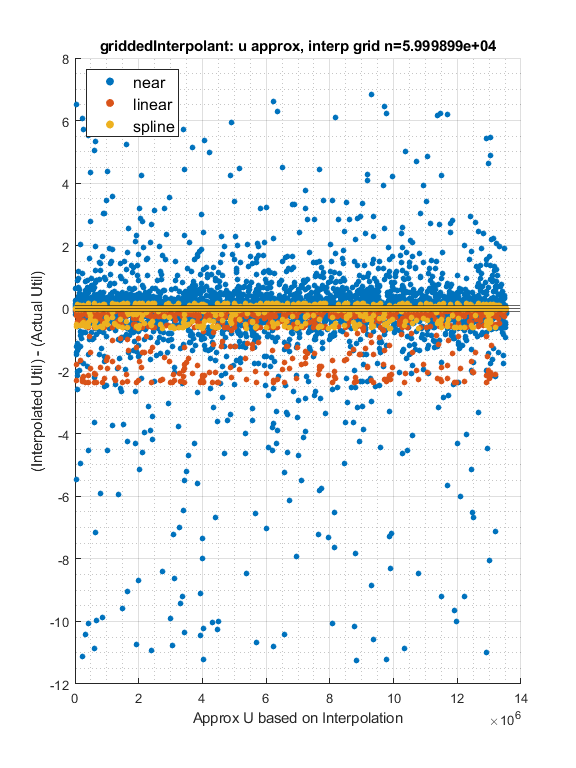

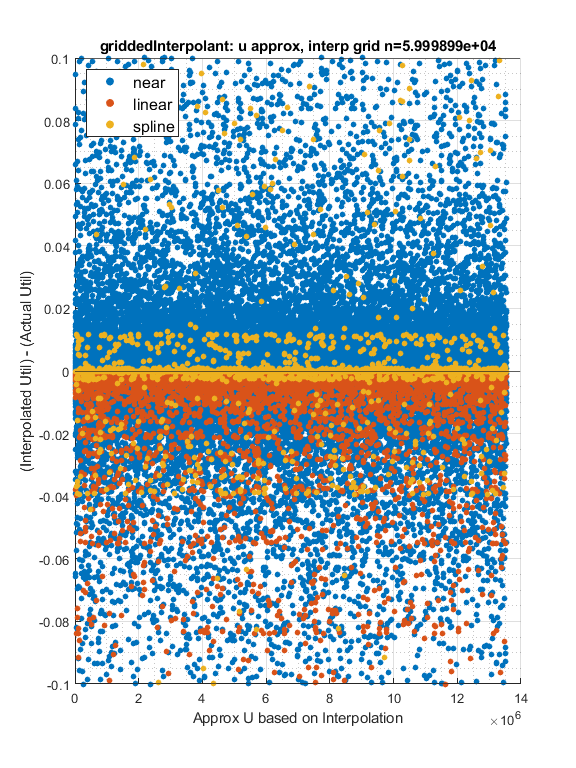

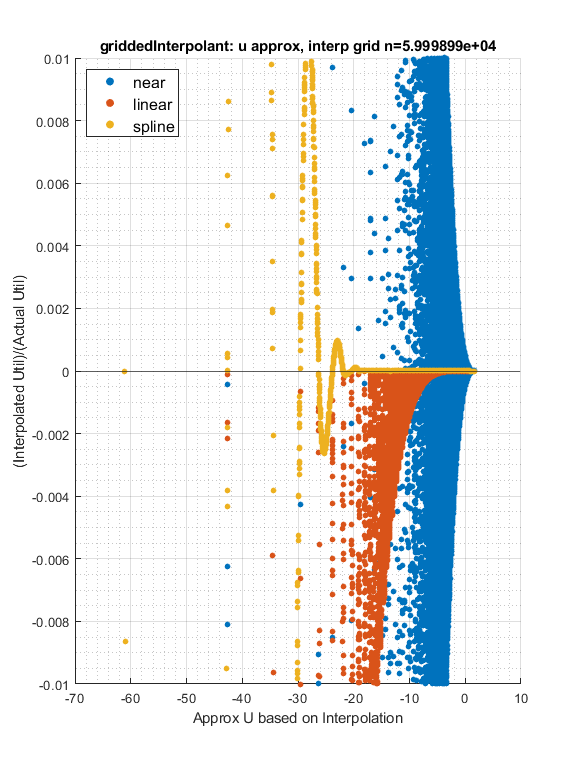

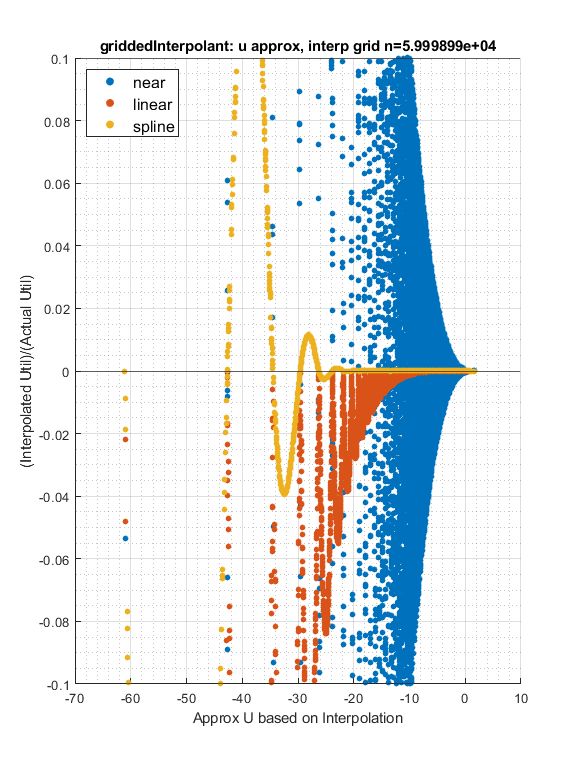

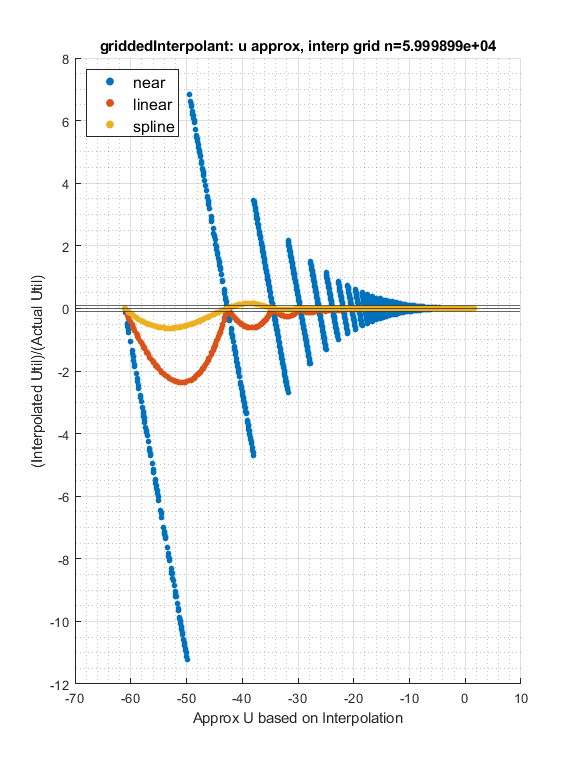

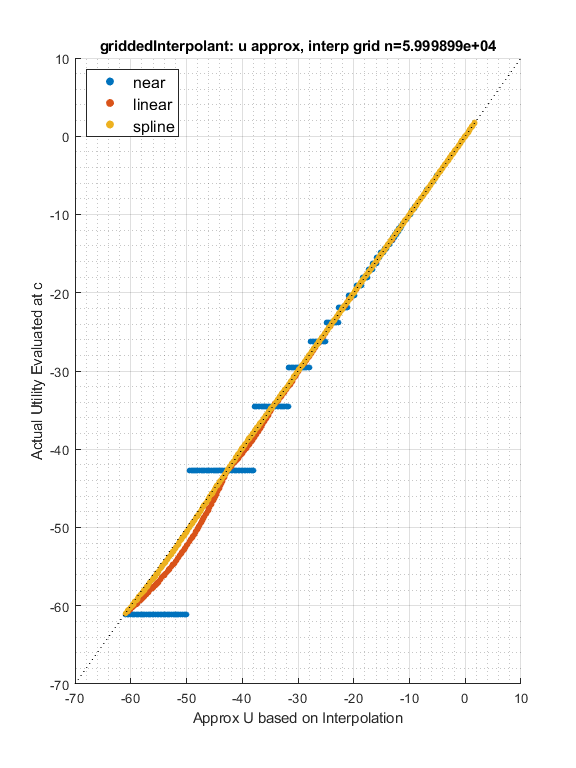

In [90]:
% 10^-3 As Interpolant Points Gap
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('fl_crra') = fl_crra;
param_map('c_min') = c_min;
param_map('c_min_for_util') = c_min_for_util;
param_map('c_gap') = c_gap;
param_map('c_max') = c_max;
param_map('it_rown') = it_rown;
param_map('st_single_double') = st_single_double;
support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_graph') = true;
ff_rational_exp_interp(param_map, support_map)